# Time series gap filling

Veronica Andreo  
2024-08-05

In this fifth time series tutorials, we will go through an important
topic when working with optical remote sensing derived data or products:
gaps and gap filling. There are several methods to perform missing data
imputation. Here, we’ll only demonstrate the usage of GRASS tools that
allow us to perform gap filling in time, also called temporal
interpolation. Specifically, we’ll show how to reconstruct missing data
using:

-   [t.rast.gapfill](https://grass.osgeo.org/grass-stable/manuals/t.rast.gapfill.html),
-   [r.hants](https://grass.osgeo.org/grass-stable/manuals/addons/r.hants.html),
    and
-   [r.series.lwr](https://grass.osgeo.org/grass-stable/manuals/addons/r.series.lwr.html).

> **Setup**
>
> This tutorial can be run locally or in Google Colab. However, make
> sure you install GRASS 8.4+, download the LST sample data and set up
> your project as explained in the
> [first](time_series_management_and_visualization.qmd) time series
> tutorial.

There are different types of gaps that we might want/need to fill when
working with time series data: - full maps missing, e.g., a daily time
series where some days are missing because product tiles are missing
from the archive, or when we want to interpolate from weekly to daily
data - (some) maps in the time series have missing data/gaps because of
clouds, snow, product quality flags applied, etc.

## Full maps missing

For the case of full maps missing, GRASS offers simple linear
interpolation in time through the
[t.rast.gapfill](https://grass.osgeo.org/grass-stable/manuals/t.rast.gapfill.html)
tool. Let’s see an example: we will first aggregate our daily LST time
series with a monthly granularity, then make a copy of it using
[t.copy](https://grass.osgeo.org/grass-stable/manuals/t.copy.html),
unregister a couple of maps here and there with
[t.unregister](https://grass.osgeo.org/grass-stable/manuals/t.unregister.html),
apply a temporal linear interpolation with *t.rast.gapfill* and compare
the results.

In [2]:
# Aggregate daily time series into monthly
gs.run_command("t.rast.aggregate",
               input="lst_daily",
               output="lst_monthly",
               basename="lst_monthly",
               method="average",
               granularity="1 months",
               suffix="gran")

In [3]:
# Create a copy
gs.run_command("t.copy",
               input="lst_monthly",
               output="lst_monthly_copy")

# Unregister maps from lst_monthly_copy
# Note that we remove 1, 2 and 3 consecutive maps in different periods of the year
to_unregister = "lst_monthly_2014_03,lst_monthly_2014_10,lst_monthly_2014_11,lst_monthly_2015_06,lst_monthly_2015_07,lst_monthly_2015_08"

gs.run_command("t.unregister",
               input="lst_monthly_copy",
               maps=to_unregister)

# Check gaps
import pandas as pd
pd.DataFrame(gs.parse_command("t.rast.list",
                              input="lst_monthly_copy",
                              method="deltagaps",
                              format="csv")))

In [4]:
# Fill gaps
gs.run_command("t.rast.gapfill",
               input="lst_monthly_copy",
               basename="gaps")

# Check gaps again and compare values with lst_monthly
filled = gs.parse_command("t.rast.list",
                          input="lst_monthly_copy",
                          columns="name,min,max",
                          where="start_time < '2016-01-01'",
                          format="json")
orig = gs.parse_command("t.rast.list",
                        input="lst_monthly",
                        columns="name,min,max",
                        where="start_time < '2016-01-01'",
                        format="json")
pd.concat([pd.DataFrame(orig["data"]),
           pd.DataFrame(filled["data"]).add_suffix("_filled")], axis=1)

In [5]:
# Plot the two time series for the city of Trento
!g.gui.tplot strds=lst_monthly,lst_monthly_copy \
  coordinates=4410837,2559852 \
  title="Trento daily LST" xlabel="Time" ylabel="LST (C)" \
  size=800,500 output=trento_gapfilled.png

<figure>
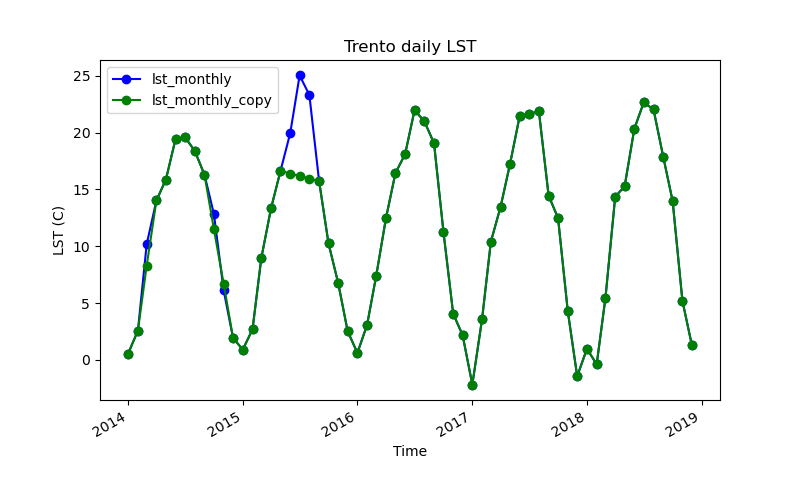
<figcaption aria-hidden="true">Linear interpolation of LST time
series</figcaption>
</figure>

> **Note**
>
> [t.unregister](https://grass.osgeo.org/grass-stable/manuals/t.unregister.html)
> allows us to remove maps from the temporal database or from a STRDS
> without actually removing them from the mapset, i.e., we only remove
> their timestamp and hence their record in the STRDS object.

## Maps with holes

For the case when maps have no data areas (i.e. holes or gaps) because
of cloud or cloud shadow masking, or as a result of QA flags
application, two GRASS tools can be used, namely
[r.hants](https://grass.osgeo.org/grass-stable/manuals/addons/r.hants.html)
or
[r.series.lwr](https://grass.osgeo.org/grass-stable/manuals/addons/r.series.lwr.html).
When to use one or the other will mostly depend on the variable that the
time series represent (i.e., temperature, NDVI, chlorophyll, etc.) and
its granularity (i.e., hourly, daily, weekly, monthly, etc.).

### Simulating the holes

To demonstrate the use of *r.hants* and *r.series.lwr* with our LST time
series, we will simulate the occurrence of clouds by randomly masking
different provinces in our study area. This will be a very simplified
example for demonstration purposes only. A proper example of how to mask
clouds and apply quality assessment flags will be developed in a
different series of tutorials.

We clip the provinces vector map with the computational region in order
to get the list of polygons’ ids or *cat* values, that we’ll use as
*“clouds”*.

In [6]:
# Clip Italy provinces to the computational region
gs.run_command("v.clip",
               input="italy_borders_2",
               output="italy_borders_2_clip",
               flags="r")

# Get unique categories
cats = gs.parse_command("v.category",
                        input="italy_borders_2_clip",
                        option="print")

cats = list(cats.keys())

Then we list the maps over which we will create the gaps.

In [7]:
# Get list of monthly maps
maps = gs.parse_command("t.rast.list",
                         input="lst_monthly",
                         columns="name",
                         method="comma",
                         flags="u")

maps = list(maps.keys())

Finally, we actually use 4 random polygons to create holes in each map
of the monthly LST time series. Basically, for each map of the series,
we apply an inverse mask of 4 random polygons, we overwrite the maps to
actually get the holes (i.e., *MASK* is otherwise virtual), and we
remove the mask.

In [8]:
import random

for i in range(len(maps)):
    gs.run_command("r.mask",
                   vector="italy_borders_2_clip",
                   cats=random.sample(cats, 4),
                   flags="i")
    gs.mapcalc(exp=f"{maps[i]} = {maps[i]}")

gs.run_command("r.mask", flags="r")

Let’s check the holes we created:

In [9]:
gaps = gj.Map()
gaps.d_rast(map="lst_monthly_2017_01")
gaps.show()

### Filling the holes

#### Harmonic analysis of time series (HANTS)

[r.hants](https://grass.osgeo.org/grass-stable/manuals/addons/r.hants.html)
performs a **Harmonic ANalysis of Time Series (HANTS)** in order to
estimate missing values and identify outliers. This algorithm considers
only the most significant frequencies expected to be present in the time
profiles (e.g. determined from a preceding Fast Fourier Transform
analysis), and applies a least squares curve fitting procedure based on
harmonic components (sines and cosines).

The option `nf`, number of frequencies, should be carefully chosen. As a
rule of thumb, nf should be at least the estimated periodicity plus 3,
e.g. for NDVI with an annual cycle (one peak per year), the number of
frequencies should be at least 4 when analyzing one year. The number of
frequencies should not be too large, either. Otherwise, outliers can no
longer be identified because of overfitting. Moreover, the number of
frequencies should be smaller than n input maps / 2 if missing values
should be reconstructed.

In [10]:
# Install extension
gs.run_command("g.extension", extension="r.hants")

In [11]:
# Basic usage of r.hants
gs.run_command("r.hants",
               input=maps,
               nf=4,
               base_period=12)

Other *r.hants* options and flags to adjust the fit can be found at the
tool manual page:
<https://grass.osgeo.org/grass-stable/manuals/addons/r.hants.html> and
also within the [original
publication](https://www.tandfonline.com/doi/abs/10.1080/014311600209814).

In [12]:
# List filled maps
hants_maps = gs.list_grouped(type="raster",
                             pattern="*hants")["italy_LST_daily"]

In [13]:
# Create new time series
gs.run_command("t.create",
               output="lst_monthly_hants",
               type="strds",
               temporaltype="absolute",
               title="Gap-filled monthly LST",
               description="HANTS gap-filled monthly LST - North Italy, 2014-2018")

In [14]:
# register maps
gs.run_command("t.register",
               flags="i",
               input="lst_monthly_hants",
               type="raster",
               maps=hants_maps,
               start="2014-01-01",
               increment="1 months")

In [15]:
# Print time series info
gs.run_command("t.info", input="lst_monthly_hants")

Let’s see a plot.

In [16]:
!g.gui.tplot strds=lst_monthly_hants,lst_monthly \
  coordinates=4410837,2559852 \
  title="Trento reconstructed LST" xlabel="Time" ylabel="LST (C)" \
  size=800,500 output=trento_hants.png

<figure>
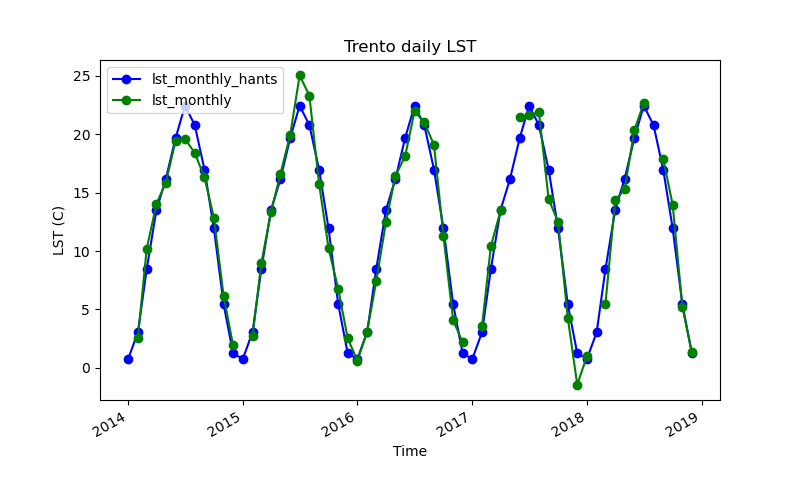
<figcaption aria-hidden="true">HANTS interpolation of LST time
series</figcaption>
</figure>

It is important to highlight that *r.hants* will fit a single model to
the whole input time series. For multiple years, that might not be the
best option because interannual variability will not be accounted for.
So, for the case of multiple years, it is recommended to run years
separately and then merge the results.

> **Note**
>
> Note that *r.hants* will reconstruct all cells within the input maps,
> whether they have gaps or not. If we want to keep the original values,
> we could patch the original series with the reconstructed result. That
> could be done as follows:
>
> ``` python
> # Patching
> for i, j in zip(maps, hants_maps):
>     print(i, j)
>     out=f"{j}_patch"
>     gs.run_command("r.patch",
>                    input=[i, j],
>                    output=out)
> ```

#### Local weighted regression

[r.series.lwr](https://grass.osgeo.org/grass-stable/manuals/addons/r.series.lwr.html)
performs a local weighted regression (LWR) in time in order to estimate
missing values and identify outliers. For each observation in the time
series, the neighbor values in time are used to estimate a polynomial
function that best fits the observations. The values are weighted
according to their distance in time to the current observation. Values
that are farther away get lower weights. The difference among the weight
functions lies in how strongly the current observation is emphasized
with respect to its temporal neighbors.

The option `order` determines the order of the polynomial function used
to fit the observations. An order of 0 is a weighted average, an order
of 1 is a linear regression. Recommended is `order=2`.

All gaps in the time series are by default interpolated, as long as the
time series contains sufficient non-NULL observations. Optionally, the
maximum size of gaps to be interpolated can be set with the `maxgap`
option.

The module uses an adaptive bandwidth to fit the polynomial and searches
for: order + 1 + dod valid values around the current observation. The
degree of over-determination (`dod`) is the user defined number of extra
temporal neighbors that should be considered for the estimation of the
value at each time step.

Just for comparison purposes, we’ll use the `lst_monthly` time series.
However, *r.series.lwr* is known to be more effective when there’s no
such a clear cyclic pattern or in smaller granularities, like daily or
weekly, when data shows more variation.

In [18]:
# Install extension
gs.run_command("g.extension", extension="r.series.lwr")

In [19]:
# Run r.series.lwr
gs.run_command("r.series.lwr",
                input=maps,
                suffix="_lwr",
                order=2,
                weight="tricube")

> **Note**
>
> Other *r.series.lwr* options and flags to adjust the fit can be found
> at the tool manual page:
> <https://grass.osgeo.org/grass-stable/manuals/addons/r.series.lwr.html>.

Let’s create a time series and plot the results.

In [20]:
# List filled maps
lwr_maps = gs.list_grouped(type="raster",
                           pattern="*lwr")["italy_LST_daily"]

In [21]:
# Create new time series
gs.run_command("t.create",
               output="lst_monthly_lwr",
               type="strds",
               temporaltype="absolute",
               title="Gap-filled monthly LST",
               description="LWR gap-filled monthly LST - North Italy, 2014-2018")

In [22]:
# register maps
gs.run_command("t.register",
               flags="i",
               input="lst_monthly_lwr",
               type="raster",
               maps=lwr_maps,
               start="2014-01-01",
               increment="1 months")

In [23]:
# Print time series info
gs.run_command("t.info", input="lst_monthly_hants")

In [24]:
!g.gui.tplot strds=lst_monthly_lwr,lst_monthly \
  coordinates=4410837.455830389,2559852.473498233 \
  title="Trento reconstructed LST" xlabel="Time" ylabel="LST (C)" \
  size=800,500 output=trento_lwr.png

<figure>
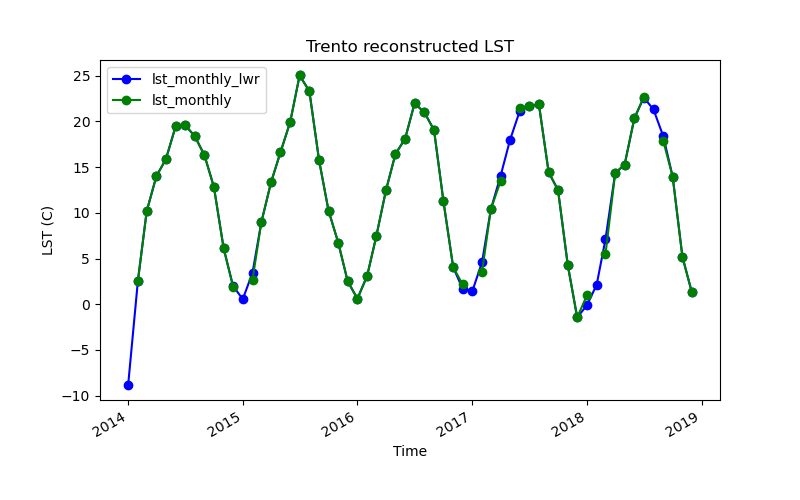
<figcaption aria-hidden="true">LWR interpolation of LST time
series</figcaption>
</figure>

> **Note**
>
> Note that there’s an overshoot towards negative values because of
> missing data in the first date. Extrapolation can be avoided by using
> the `i` flag for *interpolation only*.

### Comparison of HANTS and LWR results

There are no major differences among the results of these two
reconstructing methods, probably because it is a smoothed time series.
But have a look at a comparison of applying HANTS and LWR to a
Chlorophyll-a time series with 8-day granularity:

![Chlorophyll data reconstruction with
HANTS](https://grasswiki.osgeo.org/w/images/Cla_vs_cla_hants.png)
![Chlorophyll data reconstruction with
LWR](https://grasswiki.osgeo.org/w/images/Cla_vs_cla_lwr.png)

More details can be found in the [Filling and Reconstructing time
series](https://grasswiki.osgeo.org/wiki/Temporal_data_processing#Filling_and_reconstructing_time_series_data_with_gaps)
of the temporal data processing wiki page.

## References

-   Roerink, G., Menenti, M., Verhoef, W. 2000. *Reconstructing
    cloudfree NDVI composites using Fourier analysis of time series.*
    International Journal of Remote Sensing, 21 (9), 1911-1917.
    [DOI](http://dx.doi.org/10.1080/014311600209814).
-   Gebbert, S., Pebesma, E. 2014. *TGRASS: A temporal GIS for field
    based environmental modeling.* Environmental Modelling & Software
    53, 1-12. [DOI](http://dx.doi.org/10.1016/j.envsoft.2013.11.001).
-   Gebbert, S., Pebesma, E. 2017. *The GRASS GIS temporal framework.*
    International Journal of Geographical Information Science 31,
    1273-1292. [DOI](http://dx.doi.org/10.1080/13658816.2017.1306862).
-   [Temporal data
    processing](https://grasswiki.osgeo.org/wiki/Temporal_data_processing)
    wiki page.

------------------------------------------------------------------------

The development of this tutorial was funded by the US [National Science
Foundation (NSF)](https://www.nsf.gov/), award
[2303651](https://www.nsf.gov/awardsearch/showAward?AWD_ID=2303651).